In [405]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import seaborn as sns

In [406]:
df = pd.read_csv('Pima_data.csv')
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)
df.sample(8)

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
498,498,7.0,195.0,70.0,33.0,145.0,25.1,0.163,55,1.0
174,174,2.0,75.0,64.0,24.0,55.0,29.7,0.370,33,0.0
684,684,5.0,136.0,82.0,NaN,NaN,NaN,0.640,69,0.0
301,301,2.0,144.0,58.0,33.0,135.0,31.6,0.422,25,1.0
17,17,7.0,107.0,74.0,NaN,NaN,29.6,0.254,31,1.0
605,605,1.0,124.0,60.0,32.0,NaN,35.8,0.514,21,0.0
307,307,NaN,137.0,68.0,14.0,148.0,24.8,0.143,21,0.0
61,61,8.0,133.0,72.0,NaN,NaN,32.9,0.270,39,1.0


In [407]:
df.isna().sum()

index                         0
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Text(0.5, 1.0, 'NaNs in data in %')

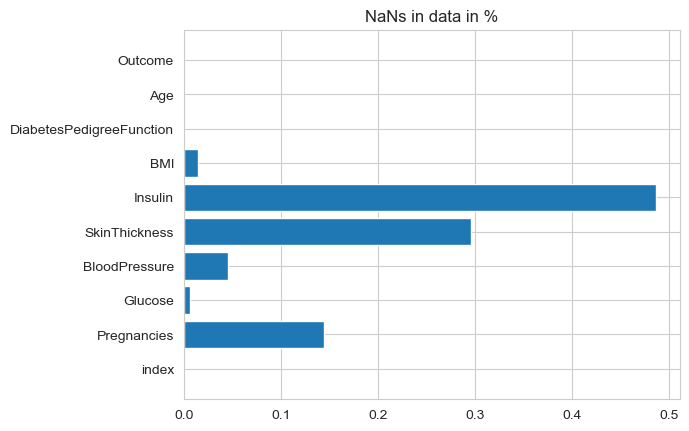

In [408]:
plt.barh(df.columns, df.isna().mean())
plt.title('NaNs in data in %')

A lot of missing values, so I'm gonna drop Insulin and SkinThickness

(Otherwise Imputation can create/stronger bias)

In [409]:
threshold = 0.75
df.drop(columns=['index'], inplace=True)
col_mask = df.isna().mean(axis=0) < (1-threshold)
row_mask = df.isna().mean(axis=1) < (1-threshold)
df = df.loc[row_mask, col_mask]
df.reset_index(inplace=True, drop=True)

In [410]:
%%capture
!pip install missingno

In [411]:
import missingno

<Axes: >

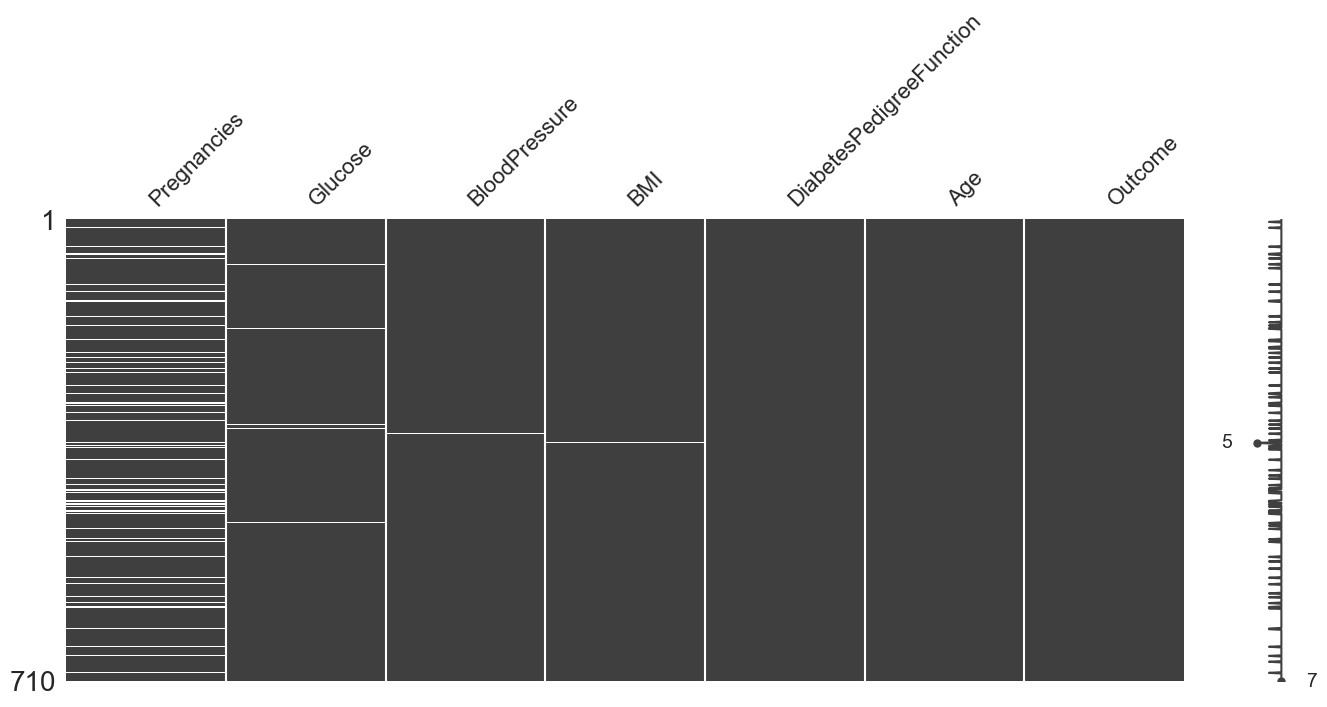

In [412]:
missingno.matrix(df, figsize=(16,6))

<Axes: >

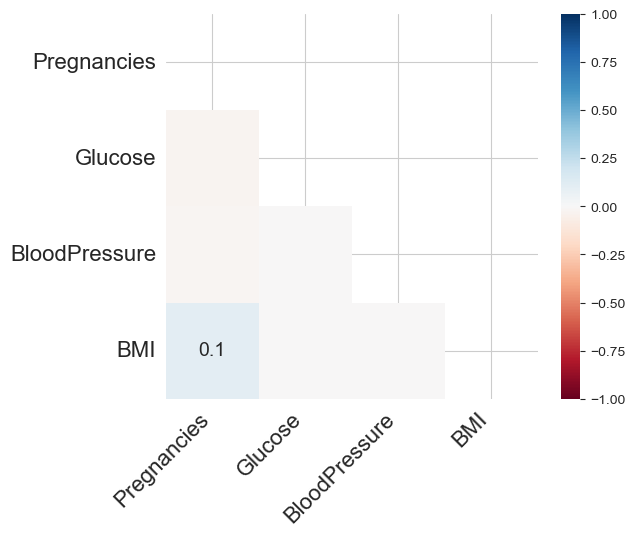

In [413]:
missingno.heatmap(df, figsize=(6,5))

In [414]:
df.describe()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
count,632.000000,705.000000,708.000000,709.000000,710.000000,710.000000,710.000000
mean,4.474684,122.130496,72.320621,32.530183,0.476368,33.261972,0.347887
std,3.229125,30.857674,12.394175,6.855448,0.333677,11.637646,0.476636
min,1.000000,44.000000,24.000000,18.200000,0.084000,21.000000,0.000000
25%,2.000000,99.000000,64.000000,27.600000,0.245000,24.000000,0.000000
50%,4.000000,117.000000,72.000000,32.400000,0.380500,29.000000,0.000000
75%,7.000000,142.000000,80.000000,36.700000,0.626750,41.000000,1.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000,1.000000


In [415]:
df_copy = df.copy()

In [416]:
def draw_histplot(d):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(2):
        for j in range(3):
            col = d.columns[i * 3 + j]
            sns.histplot(d[col], ax=axes[i,j], kde=True)


As we gonna do kNN imputation let's scale data

In [417]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

scaler = sk.preprocessing.RobustScaler()
X_scaled = scaler.fit_transform(X)

In [418]:
df_scaled = pd.DataFrame(X_scaled, columns=df_copy.columns[:-1])

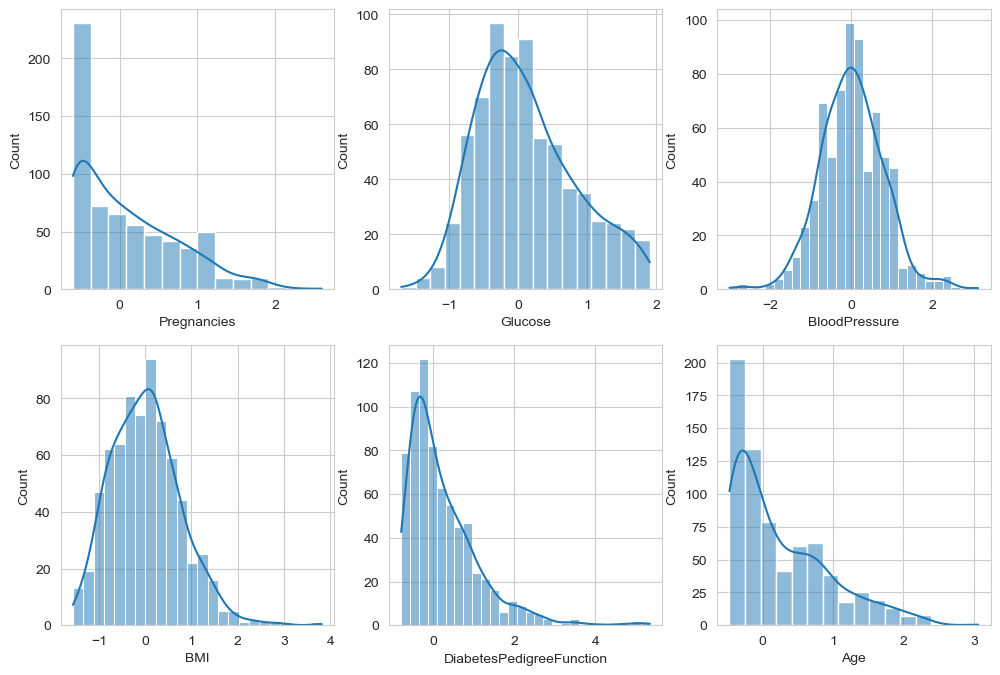

In [419]:
draw_histplot(df_scaled)

In [420]:
n = 8

knn_imputer = sk.impute.KNNImputer(n_neighbors=n)
X_knn = knn_imputer.fit_transform(X_scaled)

In [421]:
df_scaled_knn = pd.DataFrame(X_knn, columns=df_copy.columns[:-1])

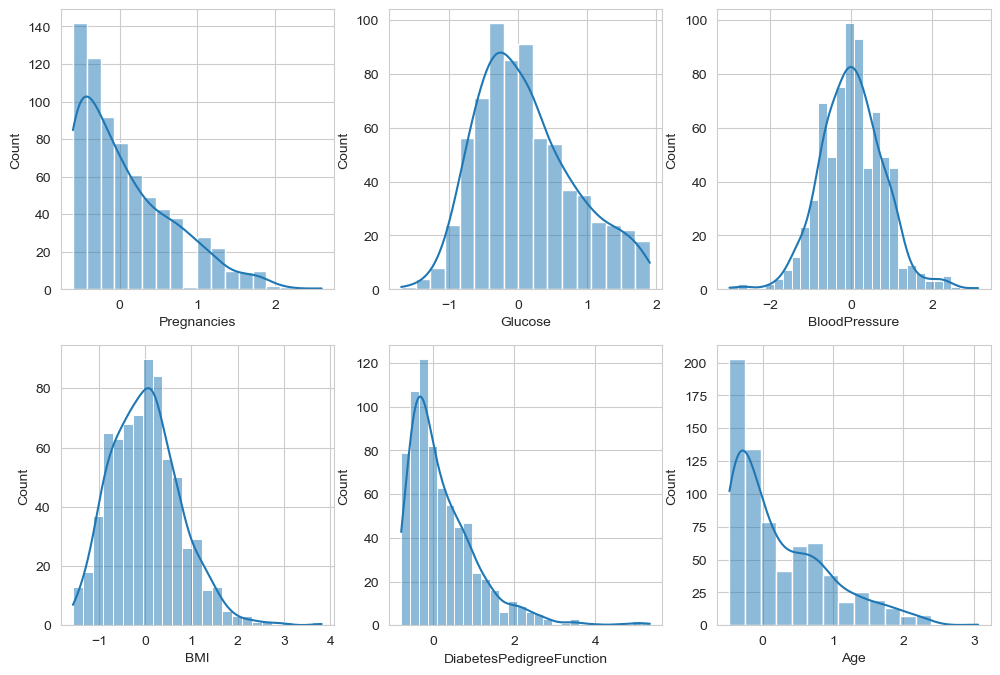

In [422]:
draw_histplot(df_scaled_knn)

With ``n = 8`` they look alike (except Pregnancies as there were plenty on missing values => dist grew in height a lil bit)

In [423]:
from sklearn.experimental import enable_iterative_imputer

In [424]:
linear_imputer = sk.impute.IterativeImputer(estimator=sk.linear_model.LinearRegression(), max_iter=100)
X_linear = linear_imputer.fit_transform(X_scaled)

In [425]:
df_scaled_linear = pd.DataFrame(X_linear, columns=df_copy.columns[:-1])

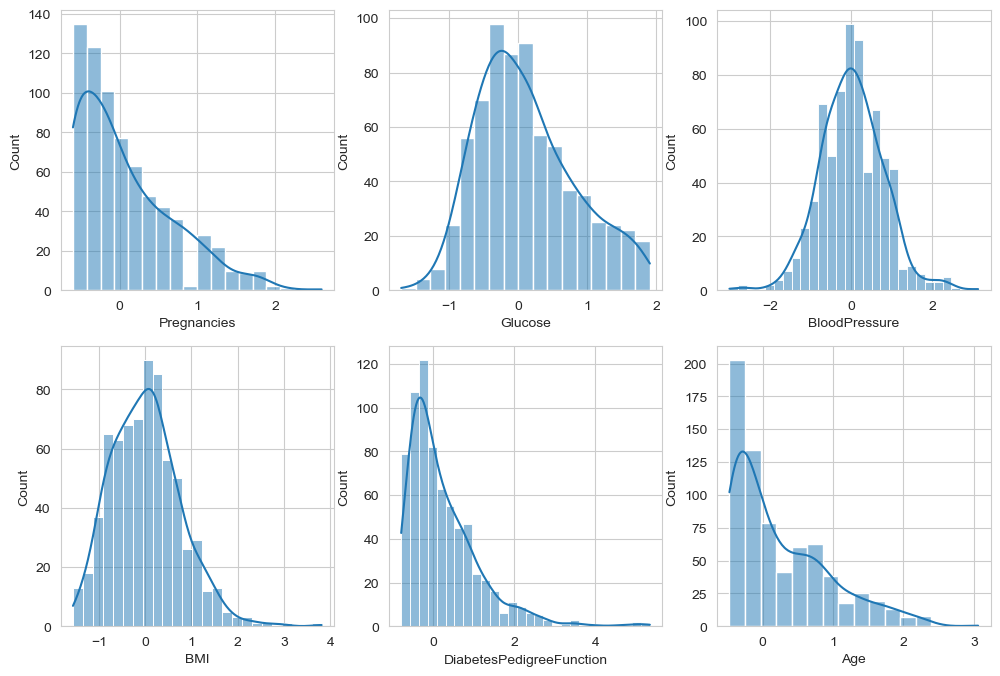

In [426]:
draw_histplot(df_scaled_linear)

In [427]:
df_final = pd.concat([df_scaled_linear, y], axis=1)

In [428]:
df_final

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.400000,0.720930,0.000,0.131868,0.645711,1.235294,1.0
1,-0.600000,-0.744186,-0.375,-0.637363,-0.077276,0.117647,0.0
2,0.800000,1.534884,-0.500,-1.000000,0.763589,0.176471,1.0
3,-0.600000,-0.651163,-0.375,-0.472527,-0.559267,-0.470588,0.0
4,-0.057198,0.465116,-2.000,1.175824,4.996726,0.235294,1.0
...,...,...,...,...,...,...,...
705,1.200000,-0.372093,0.250,0.054945,-0.548788,2.000000,0.0
706,-0.400000,0.116279,-0.125,0.483516,-0.106090,-0.117647,0.0
707,0.200000,0.093023,0.000,-0.681319,-0.354944,0.058824,0.0
708,-0.600000,0.209302,-0.750,-0.252747,-0.082515,1.058824,1.0


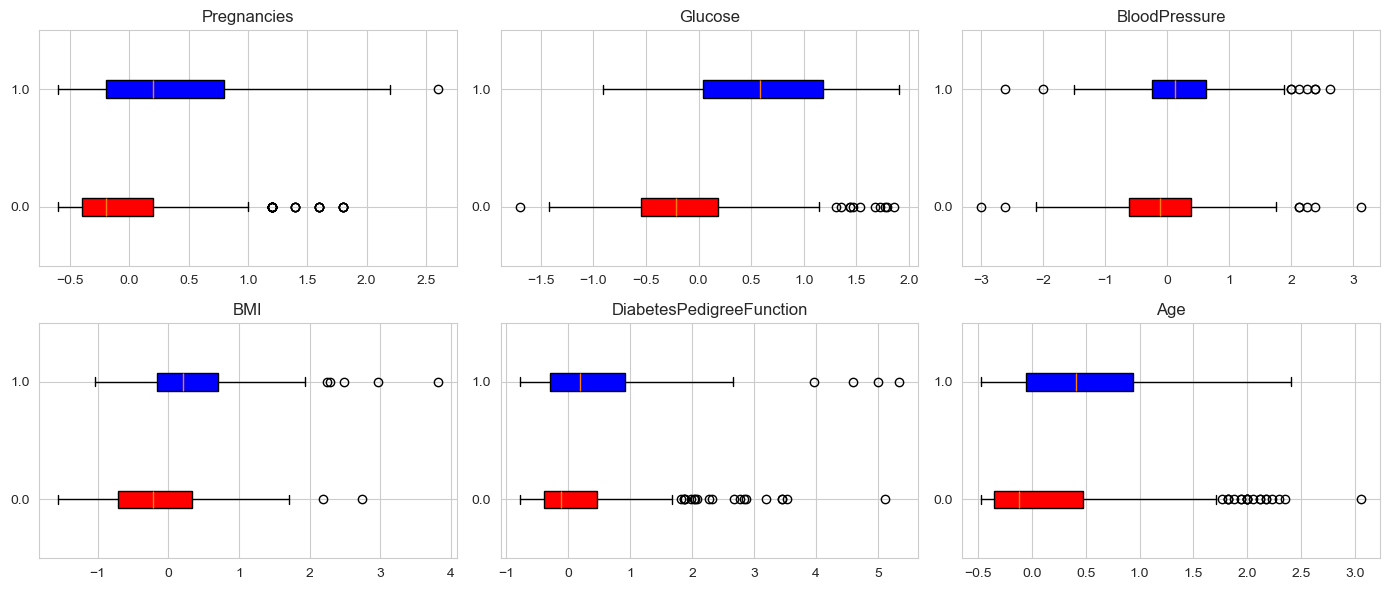

In [433]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))
for i in range(2):
    for j in range(3):
        col = df_final.columns[i * 3 + j]

        labels = sorted(df_final['Outcome'].unique().tolist())
        colors = ['red', 'blue']

        data = df_final.dropna().groupby('Outcome')[col].apply(list)

        bplot = ax[i][j].boxplot(data, vert=False, patch_artist=True, tick_labels=labels, showfliers=True)

        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        ax[i][j].set_title(col)
fig.tight_layout()
plt.show()